This notebook will be used to determine if I should be using Active Hours or Subsesion Hours for my Heavy User analysis.

In [2]:
import pyspark.sql.functions as F
import pyspark.sql.types as st
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

### Prepare Data

In [4]:
#Global variables
sample_id = 42
week_1_start = '20180923'
week_1_end = '20180929'
day_1_date = '20180926'

In [5]:
ping_query = """
    SELECT
        client_id,
        coalesce(scalar_parent_browser_engagement_total_uri_count, 0) AS uri_count,
        coalesce(scalar_parent_browser_engagement_active_ticks, 0) AS active_ticks,
        (coalesce(scalar_parent_browser_engagement_active_ticks, 0))*5/3600 AS active_hours,        
        subsession_length,
        (subsession_length/3600) AS subsession_hours,
        session_length,
        profile_subsession_counter,
        subsession_counter,
        submission_date_s3,
        session_start_date,
        subsession_start_date,
        reason,
        active_addons_count,
        scalar_parent_browser_engagement_max_concurrent_tab_count AS tab_count,
        scalar_parent_browser_engagement_max_concurrent_window_count AS window_count,
        scalar_parent_browser_engagement_unique_domains_count AS domains_count,
        profile_creation_date,
        profile_reset_date,
        previous_build_id,
        normalized_channel,
        os,
        normalized_os_version,
        windows_build_number,
        install_year,
        creation_date,
        distribution_id,
        submission_date,
        app_build_id,
        app_display_version,
        update_channel,
        update_enabled,
        update_auto_download,
        active_experiment_branch,
        timezone_offset,
        vendor,
        is_default_browser,
        default_search_engine,
        devtools_toolbox_opened_count,
        client_submission_date,
        places_bookmarks_count,
        places_pages_count,
        scalar_content_telemetry_event_counts AS telem_event_counts,
        scalar_parent_browser_engagement_tab_open_event_count AS tab_event_count,
        scalar_parent_browser_engagement_window_open_event_count AS window_event_count,
        scalar_parent_browser_errors_collected_count AS errors_collected_count,
        scalar_parent_devtools_current_theme AS current_theme,
        scalar_parent_formautofill_availability AS formautofill_availability,
        scalar_parent_media_page_count AS media_page_count, 
        country,
        city,
        geo_subdivision1,
        locale,
        antivirus,
        antispyware,
        firewall,
        session_id,
        subsession_id,
        sync_configured,
        sync_count_desktop,
        sync_count_mobile,
        disabled_addons_ids,
        active_theme,
        user_prefs,
        experiments,
        sample_id,
        document_id
    FROM main_summary
    WHERE 
        app_name='Firefox'
        AND submission_date_s3 >= '{}'
        AND submission_date_s3 <= '{}'
        AND sample_id = '{}'
    ORDER BY
        client_id,
        submission_date_s3,
        profile_subsession_counter
    """

# From telemetry docs for how clients_daily deteremines values
sum_query = """
    SELECT 
        client_id,
        submission_date_s3,
        sum(coalesce(scalar_parent_browser_engagement_total_uri_count, 0)) AS td_uri,
        sum(coalesce(scalar_parent_browser_engagement_active_ticks, 0)) AS td_active_ticks,      
        sum(coalesce(scalar_parent_browser_engagement_active_ticks, 0)*5/3600) AS td_active_hours,
        sum(subsession_length/3600) AS td_subsession_hours,   
        sum(CASE WHEN subsession_counter = 1 THEN 1 ELSE 0 END) AS sessions_started_on_this_day,
        mean(active_addons_count) AS active_addons_count_mean,
        max(scalar_parent_browser_engagement_max_concurrent_tab_count) AS tab_count_max,
        max(scalar_parent_browser_engagement_max_concurrent_window_count) AS window_count_max,
        max(scalar_parent_browser_engagement_unique_domains_count) AS domains_count_max,
        sum(scalar_parent_browser_engagement_tab_open_event_count) as td_tab_open_event_count,
        first(profile_creation_date) AS profile_creation_date,
        first(previous_build_id) AS previous_build_id,
        first(normalized_channel) AS normalized_channel,
        first(os) AS os,
        first(normalized_os_version) AS normalized_os_version,
        first(windows_build_number) AS windows_build_number,
        first(install_year) AS install_year,
        first(distribution_id) AS distribution_id,
        count(distinct document_id) AS pings_aggregated_by_this_row,
        first(app_build_id) AS app_build_id,
        first(app_display_version) AS app_display_version,
        first(update_channel) AS update_channel,
        first(update_enabled) AS update_enabled,
        first(update_auto_download) AS update_auto_download,
        first(timezone_offset) AS timezone_offset,
        first(vendor) AS vendor,
        first(is_default_browser) AS is_default_browser,
        first(default_search_engine) AS default_search_engine,
        sum(devtools_toolbox_opened_count) AS devtools_toolbox_opened_count_sum,
        mean(places_bookmarks_count) AS places_bookmarks_count_mean,
        mean(places_pages_count) AS places_pages_count_mean,
        sum(scalar_parent_browser_engagement_tab_open_event_count) AS td_tab_event_count,
        sum(scalar_parent_browser_engagement_window_open_event_count) AS td_window_event_count,
        first(CASE WHEN country IS NOT NULL AND country != '??' THEN country ELSE NULL END) as country,
        first(CASE WHEN country IS NOT NULL AND country != '??' 
                  THEN CASE WHEN city IS NOT NULL THEN city ELSE '??' END
                  ELSE NULL END) AS city,
        first(geo_subdivision1) AS geo_subdivision1,
        first(locale) AS locale,
        first(sync_configured) AS sync_configured,
        sum(sync_count_desktop) AS sync_count_desktop,
        sum(sync_count_mobile) AS sync_count_mobile,
        first(sample_id) AS sample_id
    FROM main_summary
    WHERE 
        app_name='Firefox'
        AND submission_date_s3 >= '{}'
        AND submission_date_s3 <= '{}'
        AND sample_id = '{}'
    GROUP BY
        1, 2
    """

In [6]:
ms_1week_ping = spark.sql(ping_query.format(week_1_start, week_1_end, sample_id))
ms_1week_sum = spark.sql(sum_query.format(week_1_start,week_1_end,sample_id))

In [7]:
ms_1week_avg = ms_1week_sum.groupBy('client_id').avg() \
    .withColumnRenamed('avg(td_uri)','avg_uri') \
    .withColumnRenamed('avg(td_active_ticks)','avg_active_ticks') \
    .withColumnRenamed('avg(td_active_hours)','avg_active_hours') \
    .withColumnRenamed('avg(td_subsession_hours)','avg_subsession_hours') \
    .withColumnRenamed('avg(sessions_started_on_this_day)','avg_sessions_started') \
    .withColumnRenamed('avg(active_addons_count_mean)','avg_addons_count') \
    .withColumnRenamed('avg(tab_count_max)','avg_tab_count') \
    .withColumnRenamed('avg(window_count_max)','avg_window_count') \
    .withColumnRenamed('avg(domains_count_max)','avg_domains_count') \
    .withColumnRenamed('avg(pings_aggregated_by_this_row)', 'avg_pings') \
    .withColumnRenamed('avg(sync_count_desktop)', 'avg_sync_desktop') \
    .withColumnRenamed('avg(sync_count_mobile)', 'avg_sync_mobile')

###Correlation

In [9]:
# How correlated are the two hours values for pings?
ms_1week_ping.stat.corr('active_hours', 'subsession_hours')

#I also tested this for a week in January (Jan 6 - Jan 12) and got this correlation: 
# 0.002202641498433819

Out[ 6 ]: 0.0038270176840663095

In [10]:
# How correlated are the two hours values for days?
ms_1week_sum.stat.corr('td_active_hours', 'td_subsession_hours')

#I also tested this for a week in January (Jan 6 - Jan 12) and got this correlation: 
# 0.014185426244677554

Out[ 7 ]: 0.02191836503366858

In [11]:
# How correlated are the two hours values averaged over a week?
ms_1week_avg.stat.corr('avg_active_hours', 'avg_subsession_hours')

# I also tested this for a week in January (Jan 6 - Jan 12) and got this correlation: 
# 0.00991343326194278

Out[ 8 ]: 0.011866386283418694

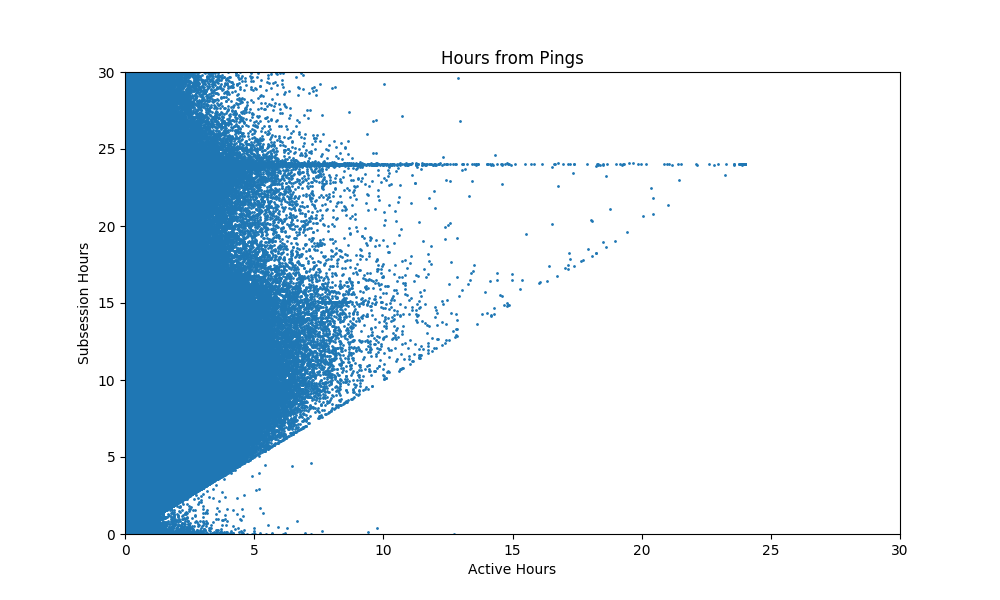

In [12]:
# Scatter plot of active hours and subsession hours for all pings
active_hrs = np.array(ms_1week_ping.rdd.map(lambda p: p.active_hours).collect())
subsession_hrs = np.array(ms_1week_ping.rdd.map(lambda p: p.subsession_hours).collect())
plt.gcf().clear()
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title('Hours from Pings')
ax1.set_xlabel('Active Hours')
ax1.set_ylabel('Subsession Hours')
top = 30
bottom = 0
ax1.set_ylim(bottom, top)
ax1.set_xlim(0, 30)
plt.scatter(active_hrs, subsession_hrs, s=1)
display(fig)

# The scatter plot for the week in January has this same shape.

The two hours values are not very correlated based on pings, daily totals or weekly averages.   
  
I could use both, or I could pick the one that I think is more reasonable based on the data.

### Data Check  
  
The maximum active hours and subsession hours should be 24 hours (25 with latency) since a ping should be sent at least daily.

For a week's worth of individual pings, the max active hours are a bit high, but the max subsession hours are very high.

In [16]:
# Look at the summary stats for ping values
display(ms_1week_ping['uri_count', 'active_ticks', 'active_hours', 'subsession_hours'].describe())

summary,uri_count,active_ticks,active_hours,subsession_hours
count,24422216,24422216,24422216,24422210
mean,33.219191084052326,122.21067768788876,0.16973705234433278,2.5797803010842917
stddev,584.7499534626065,305.27115101272256,0.42398770973989236,422.1062218802261
min,0,0,0.0,0.0
max,1350738,51622,71.69722222222222,1576182.1558333333


There are only 4 pings in a week with active hours > 24 hours, and they are all for the same client_id.

In [18]:
ms_1week_ping_cols = ms_1week_ping.columns
ms_1week_ping_cols.remove('client_id')
# Look at the pings with high active hours
ms_1week_highat = ms_1week_ping.filter('active_hours > 24')
display(ms_1week_highat.select(ms_1week_ping_cols))

uri_count,active_ticks,active_hours,subsession_length,subsession_hours,session_length,profile_subsession_counter,subsession_counter,submission_date_s3,session_start_date,subsession_start_date,reason,active_addons_count,tab_count,window_count,domains_count,profile_creation_date,profile_reset_date,previous_build_id,normalized_channel,os,normalized_os_version,windows_build_number,install_year,creation_date,distribution_id,submission_date,app_build_id,app_display_version,update_channel,update_enabled,update_auto_download,active_experiment_branch,timezone_offset,vendor,is_default_browser,default_search_engine,devtools_toolbox_opened_count,client_submission_date,places_bookmarks_count,places_pages_count,telem_event_counts,tab_event_count,window_event_count,errors_collected_count,current_theme,formautofill_availability,media_page_count,country,city,geo_subdivision1,locale,antivirus,antispyware,firewall,session_id,subsession_id,sync_configured,sync_count_desktop,sync_count_mobile,disabled_addons_ids,active_theme,user_prefs,experiments,sample_id,document_id
1,51622,71.69722222222222,623178,173.105,623178,71,1,20180927,2018-09-27T22:00:00.0+08:00,2018-09-27T22:00:00.0+08:00,daily,11,1,1,1,17267,17801,null,release,Windows_NT,6.1,7601,2016,2018-09-27T16:00:00.832Z,null,20180927,20170926190823,56.0,release,false,false,null,480,Mozilla,false,google,null,"Thu, 27 Sep 2018 16:45:38 GMT",17,99,null,null,null,null,null,false,null,HK,Shatin,NST,en-US,null,null,null,96b0c0b6-0412-41b2-9f65-a5cdbd61ad83,849c7a94-5fa7-4260-9a0a-75741f729cdc,null,null,null,null,"List({972ce4c6-7e08-4474-a285-3208198ce6fd}, false, Default, false, false, 56.0, 4, null, false, false, 17184, 17801, null, null, null, null)",null,"Map(clicktoplay-rollout -> test, e10sCohort -> multiBucket4)",42,fc38ce1f-80dc-49ff-89db-cf125f9f8483
11,35812,49.73888888888889,3559897,988.8602777777778,4183077,72,2,20180928,2018-09-27T22:00:00.0+08:00,2018-09-28T00:00:00.0+08:00,environment-change,11,7,2,1,17267,17801,null,release,Windows_NT,6.1,7601,2016,2018-09-28T01:53:19.824Z,null,20180928,20170926190823,56.0,release,false,false,null,480,Mozilla,false,google,null,"Fri, 28 Sep 2018 01:53:24 GMT",null,null,null,11,2,null,null,null,null,HK,Shatin,NST,en-US,null,null,null,96b0c0b6-0412-41b2-9f65-a5cdbd61ad83,08600af0-4fe1-4f36-b44c-542ec086d2c2,null,null,null,null,"List({972ce4c6-7e08-4474-a285-3208198ce6fd}, false, Default, false, false, 56.0, 4, null, false, false, 17184, 17801, null, null, null, null)",null,"Map(clicktoplay-rollout -> test, e10sCohort -> multiBucket4)",42,a968424f-8258-4027-8045-a84beef22938
11,35812,49.73888888888889,3559897,988.8602777777778,4183077,72,2,20180928,2018-09-27T22:00:00.0+08:00,2018-09-28T00:00:00.0+08:00,environment-change,11,7,2,1,17267,17801,null,release,Windows_NT,6.1,7601,2016,2018-09-28T01:53:19.824Z,null,20180928,20170926190823,56.0,release,false,false,null,480,Mozilla,false,google,null,"Fri, 28 Sep 2018 01:53:19 GMT",null,null,null,11,2,null,null,null,null,HK,Shatin,NST,en-US,null,null,null,96b0c0b6-0412-41b2-9f65-a5cdbd61ad83,08600af0-4fe1-4f36-b44c-542ec086d2c2,null,null,null,null,"List({972ce4c6-7e08-4474-a285-3208198ce6fd}, false, Default, false, false, 56.0, 4, null, false, false, 17184, 17801, null, null, null, null)",null,"Map(clicktoplay-rollout -> test, e10sCohort -> multiBucket4)",42,a968424f-8258-4027-8045-a84beef22938
58,21068,29.261111111111113,1075069,298.6302777777778,5281129,74,4,20180928,2018-09-27T22:00:00.0+08:00,2018-09-28T09:00:00.0+08:00,shutdown,11,7,2,1,17267,17801,null,release,Windows_NT,6.1,7601,2016,2018-09-28T04:56:20.341Z,null,20180928,20170926190823,56.0,release,false,false,null,480,Mozilla,false,google,null,"Fri, 28 Sep 2018 04:56:20 GMT",null,null,null,57,null,null,null,null,null,HK,Shatin,NST,en-US,null,null,null,96b0c0b6-0412-41b2-9f65-a5cdbd61ad83,08e588b5-6f95-42ae-957b-a45afae93309,null,null,null,null,"List({972ce4c6-7e08-4474-a285-3208198ce6fd}, false, Default, false, false, 56.0, 4, null, false, false, 17184, 1

There are 198,466 pings with subsession hours > 25 hours in one week, representing 131,870, unique client_ids.  

The subsession hours measurement looks more suspect.  We could cap the pings at 25 hours, filter out the pings or the clients with high subsession hours.  Capping the pings would maintain the information if more than one ping is submitted on the same day or if multiple users are using the same client_id.

In [20]:
# Look at the summary stats for pings with high subsession hours
ms_1week_highss = ms_1week_ping.filter('subsession_hours > 25')
display(ms_1week_highss['uri_count', 'active_ticks', 'active_hours', 'subsession_hours'].describe())

summary,uri_count,active_ticks,active_hours,subsession_hours
count,198466,198466,198466,198466
mean,75.00896879062408,270.45948928279904,0.37563817955944273,90.22430785653735
stddev,3007.248798827543,527.1559421287625,0.7321610307343916,4681.358878834005
min,0,0,0.0,25.00027777777778
max,1332438,51622,71.69722222222222,1576182.1558333333


In [21]:
# Look at the pings with high subsession hours
display(ms_1week_highss.select(ms_1week_ping_cols))

uri_count,active_ticks,active_hours,subsession_length,subsession_hours,session_length,profile_subsession_counter,subsession_counter,submission_date_s3,session_start_date,subsession_start_date,reason,active_addons_count,tab_count,window_count,domains_count,profile_creation_date,profile_reset_date,previous_build_id,normalized_channel,os,normalized_os_version,windows_build_number,install_year,creation_date,distribution_id,submission_date,app_build_id,app_display_version,update_channel,update_enabled,update_auto_download,active_experiment_branch,timezone_offset,vendor,is_default_browser,default_search_engine,devtools_toolbox_opened_count,client_submission_date,places_bookmarks_count,places_pages_count,telem_event_counts,tab_event_count,window_event_count,errors_collected_count,current_theme,formautofill_availability,media_page_count,country,city,geo_subdivision1,locale,antivirus,antispyware,firewall,session_id,subsession_id,sync_configured,sync_count_desktop,sync_count_mobile,disabled_addons_ids,active_theme,user_prefs,experiments,sample_id,document_id
0,0,0.0,119124,33.09,155247,237,2,20180923,2018-09-21T16:00:00.0+03:00,2018-09-22T02:00:00.0+03:00,daily,11,17,1,null,16337,null,null,release,Windows_NT,6.1,7601,2014,2018-09-23T09:04:42.108Z,null,20180923,20180830143136,62.0,release,true,true,null,180,Mozilla,false,google,null,"Sun, 23 Sep 2018 09:04:42 GMT",null,null,null,null,null,null,null,null,null,RO,Târgu Mureş,MS,en-GB,null,null,null,33e0a300-6f5e-4781-afdc-91cce0b9e6c8,b782af47-5ae8-48e2-8870-7c607e1ea71a,null,null,null,null,"List(default-theme@mozilla.org, false, Default, false, false, , 1, null, false, false, 0, 0, null, null, null, null)",null,null,42,30ba85d0-e0fe-4878-bfb2-f49d92502b8e
10,31,0.043055555555555555,440583,122.38416666666667,441098,159,2,20180924,2018-09-18T16:00:00.0-06:00,2018-09-18T16:00:00.0-06:00,daily,10,1,1,1,17521,null,null,release,Windows_NT,6.3,9600,2014,2018-09-24T00:51:59.972Z,null,20180924,20180830143136,62.0,release,true,true,null,-360,Mozilla,false,google,null,"Mon, 24 Sep 2018 00:54:02 GMT",null,null,null,null,null,null,null,null,null,MX,Chihuahua City,CHH,es-MX,List(Windows Defender),List(Windows Defender),List(Firewall de Windows),a3868c75-4f01-440a-ba60-e36cd494c4b1,3e162a3d-69b4-47ac-b673-63c9d5c08381,null,null,null,null,"List(default-theme@mozilla.org, false, Predeterminado, false, false, , 1, null, false, false, 0, 0, null, null, null, null)",null,null,42,fc17fec7-2aea-4fe9-b515-0540ac02ec01
747,1583,2.198611111111111,105197,29.22138888888889,105203,231,1,20180925,2018-09-24T02:00:00.0+02:00,2018-09-24T02:00:00.0+02:00,daily,11,14,2,42,17692,null,20180830143136,release,Windows_NT,10.0,17134,2018,2018-09-25T05:33:58.598Z,null,20180925,20180920131237,62.0.2,release,true,true,null,120,Mozilla,true,google,null,"Tue, 25 Sep 2018 05:33:58 GMT",null,null,null,17,2,null,null,false,null,ES,Santander,CB,es-ES,null,null,null,561a65c4-7014-424f-8624-3d51447278c1,a5777b50-e00d-4b84-81de-a67ca9100236,null,null,null,null,"List(firefox-compact-dark@mozilla.org@personas.mozilla.org, false, Oscuro, false, false, , 1, null, false, false, 0, 0, null, null, null, null)",null,null,42,97b1e55b-4c7a-4f67-9d0c-f6ed68a5629a
951,610,0.8472222222222222,99630,27.675,99635,234,1,20180926,2018-09-25T18:00:00.0+02:00,2018-09-25T18:00:00.0+02:00,daily,13,21,2,7,17692,null,null,release,Windows_NT,10.0,17134,2018,2018-09-26T20:13:19.108Z,null,20180926,20180920131237,62.0.2,release,true,true,null,120,Mozilla,true,google,null,"Wed, 26 Sep 2018 20:15:23 GMT",null,null,null,14,1,null,null,false,null,ES,Santander,CB,es-ES,List(Kaspersky Total Security),List(Kaspersky Total Security),List(Kaspersky Total Security),bc99dd6a-5740-4d43-a1d6-7f8da9728122,9d71175c-6ddb-4d8c-b589-df83d49457a5,null,null,null,null,"List(firefox-compact-dark@mozilla.org@personas.mozilla.org, false, Oscuro, false, false, , 1, null, false, false, 0, 0, null, null, null, null)",null,null,42,fec7bb97-edc4-4f5c-92af-f9004dbe94af
38,81,0.1125,107796,29.943

In [22]:
# How many distinct clients have high subsession hours?
ms_1week_highss.select('client_id').distinct().count()

Out[ 15 ]: 131870

### Conclusion

Active Hours 
* indicate when someone is actively using the browser
* will undercount times when watching Netflix or reading a long article
* data has a small standard deviation but the max values look reasonable
* only has one client id with data above the reasonable max

Subsession Hours
* will capture times when passively using the browser
* data has a very large standard deviation
* there are 131,870 client ids with data above the reasonable max

Based on all of these factors, I will use Active Hours in my Heavy User analysis.